<a href="https://colab.research.google.com/github/audalsgh/20250711/blob/main/0711_%EB%AC%B8%EC%88%98%EC%98%81%EA%B5%90%EC%88%98%EB%8B%98_%ED%9A%8C%EA%B7%80%EB%AC%B8%EC%A0%9C2%EA%B0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 선형근사를 사용하여 당뇨환자 데이터셋을 통해 1년후 진행 상황을 예측하라
- sklearn.datasets 의 load_diabetes 데이터셋을 가져옴
- 샘플수 42개, Feature수 10개 (-0.2 ~0.2)로 정규화 되있음.
- Target = 연속적인 숫자 데이터로 추론 결과를 얻기.

In [23]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True)
X = X[:, [2]]  # 10개의 특성중 2번인덱스의 특성만 사용하여, 결과의 x 형태가 (442, 10) -> (442, 1)로 변경됨
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)  # (shuffle=False) -> 원본 순서를 유지한다는 뜻.

단순선형근사 모델을 임포트해옴<br>
 .fit(X_train, y_train)  # X_train/y_train은 모델 학습용, X_test/y_test는 평가용으로 사용됨.<br>
 -> 학습용 데이터로부터 최적의 직선 방정식
𝑦
=
𝑤
𝑥
+
𝑏
의 파라미터 w,b 추정

In [24]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression().fit(X_train, y_train)

MSE = 오차 제곱의 평균으로, 값이 작을수록 예측이 실제값에 가깝다는 의미<br>
R^2 = 결정계수가 1에 가까울수록 모델이 데이터 분산을 잘 설명함. 음수가 될 수도 있음


In [25]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 2548.07
Coefficient of determination: 0.47


실행 결과로부터 알 수 있는 것: single-feature만을 이용한 linear regression은 오차 관점에서 낮은 성능을 보임

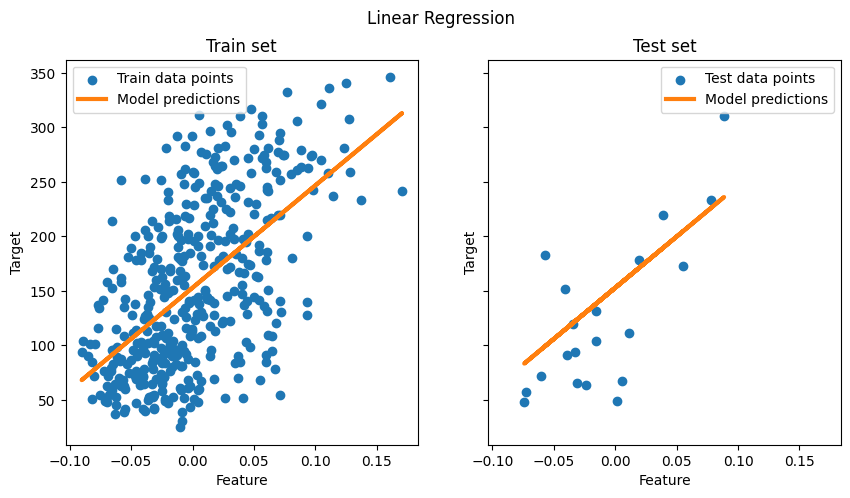

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].scatter(X_train, y_train, label="Train data points")
ax[0].plot(
    X_train,
    regressor.predict(X_train),
    linewidth=3,
    color="tab:orange",
    label="Model predictions",
)
ax[0].set(xlabel="Feature", ylabel="Target", title="Train set")
ax[0].legend()

ax[1].scatter(X_test, y_test, label="Test data points")
ax[1].plot(X_test, y_pred, linewidth=3, color="tab:orange", label="Model predictions")
ax[1].set(xlabel="Feature", ylabel="Target", title="Test set")
ax[1].legend()

fig.suptitle("Linear Regression")

plt.show()

2. KNN을 사용하여 같은 문제를 풀어라. (KNN은 분류문제와 회귀문제 모두에게 사용가능)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor  # KNN 회귀 모델
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  # 특성 스케일링

In [28]:
# 데이터세트 가져오기, 임포트한 곳에서 똑같이 가져옴
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Descript를 출력하면 데이터셋 컬럼 정보, 샘플 개수, 설명 등이 콘솔에 표시됨
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

KNN 모델 셋팅, k개의 묶음으로 데이터를 나누어, k번째는 테스트에 쓰고 나머지 묶음은 모델학습에 쓰도록 함 = Cross validation

In [29]:
# (test_size=0.2)로 전체 샘플의 20%를 테스트 세트로 분리, (random_state=42)로 분할 시드를 고정하여 재현성 보장
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN 은 거리 기반 알고리즘이므로, 모든 특성(feature)이 같은 스케일을 가져야 성능이 안정적
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # fit_transform으로 "학습 세트"의 평균·표준편차를 계산해 스케일링
X_test = scaler.transform(X_test)  # transform으로 "테스트 세트"를 같은 기준으로 변환

이제 KNN 회귀모델 생성 후, .fit(X_train, y_train)으로 모델학습에 입력

In [30]:
# (n_neighbors=5) 예측 시 가장 가까운 5개의 이웃 샘플의 타깃값 평균을 사용
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)  # X_train/y_train은 모델 학습용, X_test/y_test는 평가용으로 사용됨

KNeighborsRegressor()

학습된 KNN 모델로 테스트 특성 X_test에 대한 예측값 y_pred 계산

In [31]:
y_pred = knn_regressor.predict(X_test)

MSE = 오차 제곱의 평균으로, 값이 작을수록 예측이 실제값에 가깝다는 의미<br>
R^2 = 결정계수가 1에 가까울수록 모델이 데이터 분산을 잘 설명함. 음수가 될 수도 있음


In [32]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 3047.449887640449
R-squared: 0.42480887066066253


빨간 선(ideal fit)은 완벽히 예측했을 때
𝑦
=
𝑥
직선

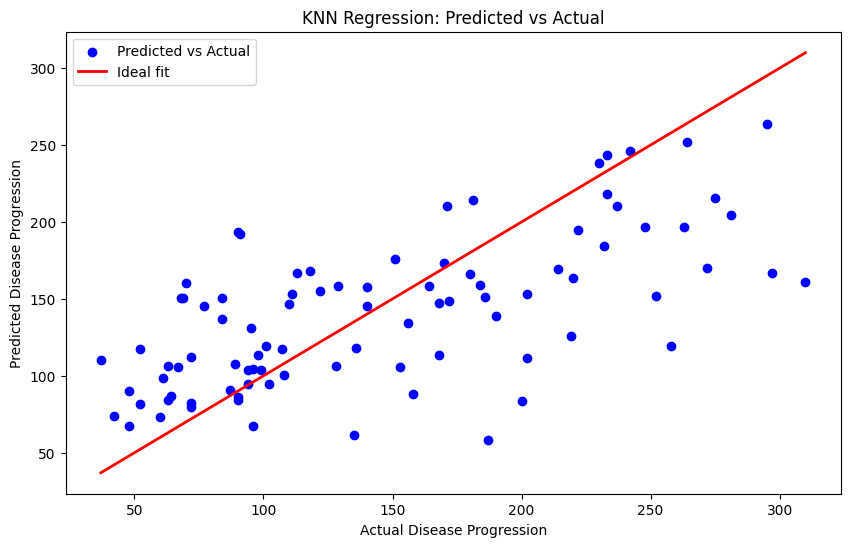

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Ideal fit')
plt.title('KNN Regression: Predicted vs Actual')
plt.xlabel('Actual Disease Progression')
plt.ylabel('Predicted Disease Progression')
plt.legend()
plt.show()